In [183]:
import json
import pickle
import json_repair
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from pathlib import Path
from pdb import set_trace
from collections import Counter


In [184]:
data_path = Path("../data/raw/framing_results/")  
processed_path = Path("../data/processed/")  

In [185]:
def get_valid_json_list(data):
    out_list = []
    for i, out in enumerate(data):
        try:
            # Check if json is already valid within brackets
            basic_fix_str = out[out.index("{"):out.rindex("}")+1]
            basic_fix_str = basic_fix_str.replace("\n","")
            json_obj = json.loads(basic_fix_str)
            assert type(json_obj) == dict
            assert len(json_obj) == 2
        except:
            # Fix json
            try:
                json_obj = json_repair.loads(out)
                assert len(json_obj) == 2
                assert type(json_obj) == dict
            except:
                out_list.append({"error": "json_out_dict error"})
                continue
        assert type(json_obj) == dict
        out_list.append(json_obj)
    return out_list

In [186]:
data_lists = {"US":[], "UK":[], "ME":[]}
for region, data_list in data_lists.items():
    for i in range(1,len([*data_path.glob(f"{region}*")])):
        data_lists[region].extend(get_valid_json_list(pkl.load(open(data_path/f"{region}_{i}.pkl", "rb"))))

In [188]:
data_dfs = {}
for region, data_list in data_lists.items():
    region_list = []
    for i, json_out in enumerate(data_list):
        json_out_list = list(json_out.values())
        try:
            json_out_dict = json_out_list[0] | json_out_list[1]
            assert len(json_out_dict) == len(json_out_list[0])+len(json_out_list[1])
            json_out_dict["index"] = i
        except:
            continue
        region_list.append(json_out_dict)
    region_df = pd.DataFrame(region_list)
    valid_columns = []
    df_len = len(region_df)
    for col_name,col in region_df.items():
        if col.isna().sum() > 0.5*df_len:
            continue
        else:
            valid_columns.append(col_name)
    region_df = region_df[valid_columns]
    region_df.reset_index()
    region_df = region_df.rename(columns={"index": "index"})
    region_df = region_df.set_index("index")
    orig_df = pd.read_csv(f"../data/raw/framing_results/selected_{region}.csv")
    orig_df = orig_df.loc[region_df.index]
    orig_df.drop(columns=["language"], inplace=True)
    merged_df = pd.concat([orig_df, region_df], axis=1)

    data_dfs[region] = merged_df
    data_dfs[region].to_json(processed_path/f"{region}_framing.jsonl", orient="records", lines=True)

### War journalism indicators

In [197]:
def recursive_count(data):
    if isinstance(data, list):
        # Check if list is empty
        if not data:
            return 0
        if isinstance(data[0], str):
            return 1
        elif isinstance(data[0], list):
            return len(data)
        else:
            return 0
    # If dict, recursively count the values
    elif isinstance(data, dict):
        count = 0
        for _, value in data.items():
            sub_value = recursive_count(value)
            count += sub_value
        return count
    # Hacky fix for the case when the data is a pandas Series
    elif isinstance(data, pd.Series):
        value = data.values[1]
        return recursive_count(value)
    elif pd.isna(data):
        return 0
    elif isinstance(data, str):
        return 1
    return 0
        
def flatten_and_count(df):
    result_list = []
    result_count_list = []
    for _, row in df.iterrows():
        result = {}
        for col_name, col_value in dict(row).items():
            result[col_name] = recursive_count(col_value)
        result_list.append(result)
        result_count = sum(result.values())
        result_count_list.append(result_count)
    return result_list, result_count_list

/var/folders/v4/1f9w3z693hv5dk6wxj46w3y80000gn/T/ipykernel_93749/2296925142.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  war_indicators['indicators_flattened'] = war_indicator_list
/var/folders/v4/1f9w3z693hv5dk6wxj46w3y80000gn/T/ipykernel_93749/2296925142.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  war_indicators['indicators_count'] = war_indicator_count
/var/folders/v4/1f9w3z693hv5dk6wxj46w3y80000gn/T/ipykernel_93749/2296925142.py:19: SettingWithCopyWarning: 
A value is trying to be set o

US 15.079333597778659 12.428798095993653
UK 14.319951826575672 13.22962665596146
ME 14.361897756528135 12.44759102611254


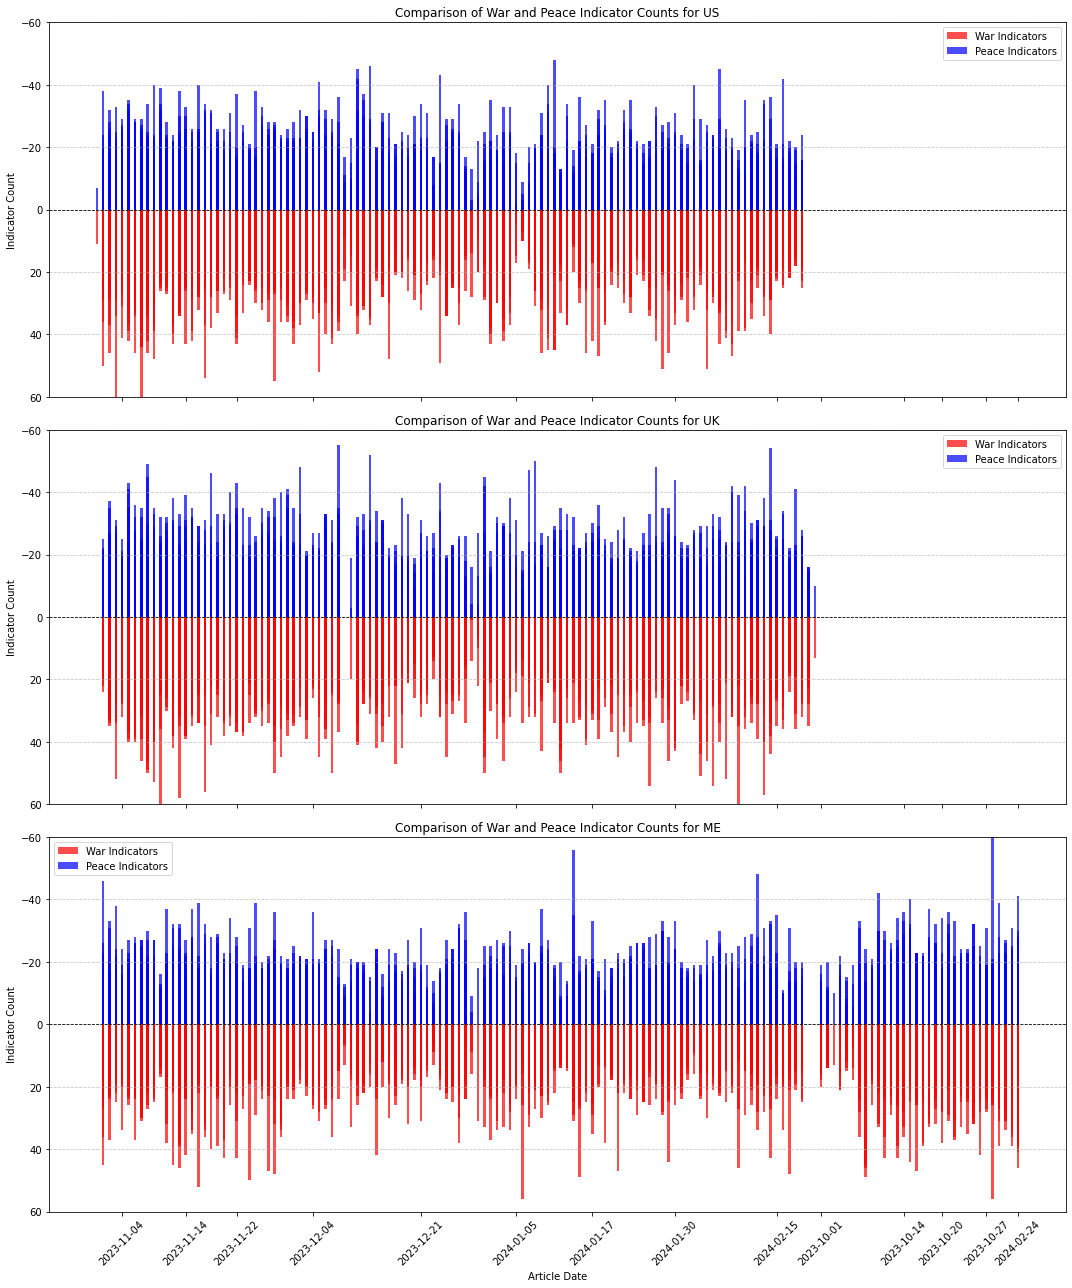

In [198]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
width = 0.4  # Width of the bars

for i, region in enumerate(["US", "UK", "ME"]):
    # Select relevant columns for war and peace indicators
    war_indicators = data_dfs[region][['adversarial_frame',
        'focus_on_elites',
        'partisan_framing', 'focus_on_visible_effects_of_war',
        'nationalistic_frame', 'military_solution']]
    peace_indicators = data_dfs[region][['peace_frame', 'focus_on_invisible_effects_of_war',
     'people_orientation', 'victim_orientation', 'peace_orientation']]

    # Flatten and count the indicators
    war_indicator_list, war_indicator_count = flatten_and_count(war_indicators)
    war_indicators['indicators_flattened'] = war_indicator_list
    war_indicators['indicators_count'] = war_indicator_count
    data_dfs[region]['war_indicators'] = war_indicators['indicators_flattened']
    peace_indicator_list, peace_indicator_count = flatten_and_count(peace_indicators)
    peace_indicators['indicators_flattened'] = peace_indicator_list
    peace_indicators['indicators_count'] = peace_indicator_count
    data_dfs[region]['peace_indicators'] = peace_indicators['indicators_flattened']
    # Add date_publish to the indicators for plotting
    war_indicators['date_publish'] = data_dfs[region]['date_publish']
    peace_indicators['date_publish'] = data_dfs[region]['date_publish']

    # Drop nans
    war_indicators = war_indicators.dropna(subset=["date_publish"])
    peace_indicators = peace_indicators.dropna(subset=["date_publish"])

    # Convert date_publish to datetime
    war_indicators['date'] = war_indicators['date_publish'].apply(lambda x: pd.to_datetime(x.split(" ")[0]))
    peace_indicators['date'] = peace_indicators['date_publish'].apply(lambda x: pd.to_datetime(x.split(" ")[0]))
    war_indicators_sorted = war_indicators.sort_values(by='date')
    peace_indicators_sorted = peace_indicators.sort_values(by='date')
    war_indicators_sorted['date'] = war_indicators_sorted['date'].dt.strftime('%Y-%m-%d')
    peace_indicators_sorted['date'] = peace_indicators_sorted['date'].dt.strftime('%Y-%m-%d')

    war_indicator_count = war_indicators_sorted['indicators_count']
    peace_indicator_count = peace_indicators_sorted['indicators_count']
    print(region, sum(war_indicator_count)/len(war_indicator_count), sum(peace_indicator_count)/len(peace_indicator_count))

    # Create a bar plot to contrast war and peace indicator counts
    indices = war_indicators_sorted['date']  # Use the 'date_publish' column for the x-axis
    axes[i].bar(indices, war_indicator_count, width, label='War Indicators', color='red', alpha=0.7)
    axes[i].bar(indices, [-count for count in peace_indicator_count], width, label='Peace Indicators', color='blue', alpha=0.7)
    axes[i].set_ylim(60, -60)

    # Add labels and title
    axes[i].set_ylabel('Indicator Count')
    axes[i].set_title(f'Comparison of War and Peace Indicator Counts for {region}')
    axes[i].axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
    axes[i].legend()
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Add shared x-axis label
plt.xlabel('Article Date')
plt.xticks(indices[::200], labels=indices[::200], rotation=45)  # Label every 200th date on the x-axis
plt.tight_layout()
plt.savefig("../data/figures/war_peace_indicators_region.png", dpi=300)
plt.show()


In [ ]:
data_dfs[region]

Index(['description', 'maintext', 'source_domain', 'title', 'url',
       'date_publish', 'region', 'title_len', 'text_len', 'adversarial_frame',
       'focus_on_elites', 'labelling_of_people', 'language',
       'partisan_framing', 'focus_on_visible_effects_of_war',
       'nationalistic_frame', 'military_solution', 'peace_frame',
       'focus_on_invisible_effects_of_war', 'peace_orientation',
       'people_orientation', 'victim_orientation', 'war_indicators',
       'peace_indicators'],
      dtype='object')

In [212]:
region_indicator_counts = {}
for region in ["US", "UK", "ME"]:
    war_counter = Counter()
    for count_dict in data_dfs[region]["war_indicators"].values:
        war_counter.update(count_dict)
    peace_counter = Counter()
    for count_dict in data_dfs[region]["peace_indicators"].values:
        peace_counter.update(count_dict)
    region_indicator_counts[region] = {"war": dict(war_counter), "peace": dict(peace_counter)}
    

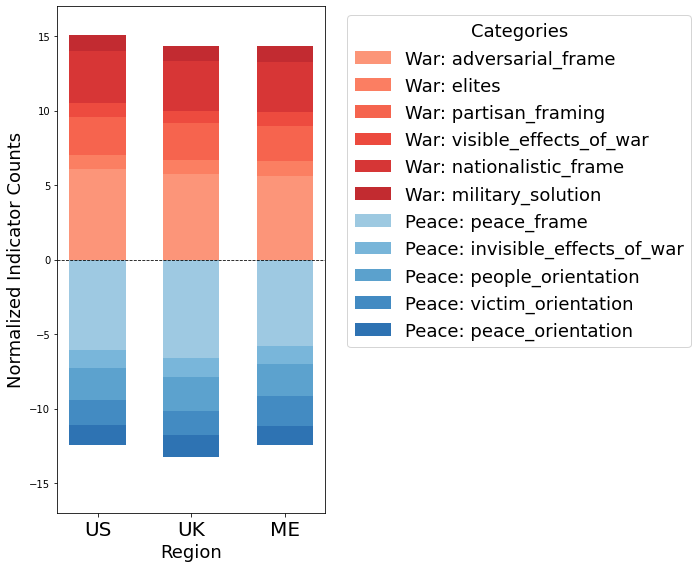

In [233]:
# Extract peace counts breakdown for each region
peace_categories = list(region_indicator_counts['US']['peace'].keys())
peace_breakdown = {region: [region_indicator_counts[region]['peace'].get(category, 0) for category in peace_categories] for region in regions}

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))
# Normalize the values by the length of articles
war_breakdown_normalized = {region: [value / len(data_dfs[region]) for value in war_breakdown[region]] for region in regions}
peace_breakdown_normalized = {region: [value / len(data_dfs[region]) for value in peace_breakdown[region]] for region in regions}

# Define new colors for better aesthetics
war_colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(war_categories)))
peace_colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(peace_categories)))

# Initialize the bottom for stacking
war_bottom = np.zeros(len(regions))
peace_bottom = np.zeros(len(regions))

# Plot each war category as a stacked bar
for i, (category, color) in enumerate(zip(war_categories, war_colors)):
    if "focus" in category:
        category = category.replace("focus_on_", "")
    values = [war_breakdown_normalized[region][i] for region in regions]
    ax.bar(x, values, width, label=f'War: {category}', bottom=war_bottom, color=color, alpha=0.9)
    war_bottom += values

# Plot each peace category as a stacked bar (negative values for better contrast)
for i, (category, color) in enumerate(zip(peace_categories, peace_colors)):
    if "focus" in category:
        category = category.replace("focus_on_", "")
    values = [-peace_breakdown_normalized[region][i] for region in regions]
    ax.bar(x, values, width, label=f'Peace: {category}', bottom=peace_bottom, color=color, alpha=0.9)
    peace_bottom += values

# Add labels, title, and legend
ax.set_xlabel('Region', fontsize=18)
ax.set_ylabel('Normalized Indicator Counts', fontsize=18)
# ax.set_title('Normalized Breakdown of War and Peace Indicator Counts by Region', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(regions, fontsize=20)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, title_fontsize=18)
ax.set_ylim(-17, 17)
plt.tight_layout()
plt.savefig("../data/figures/war_peace_indicator_counts.png", dpi=300)
plt.show()

#### Code for stacked bar chart

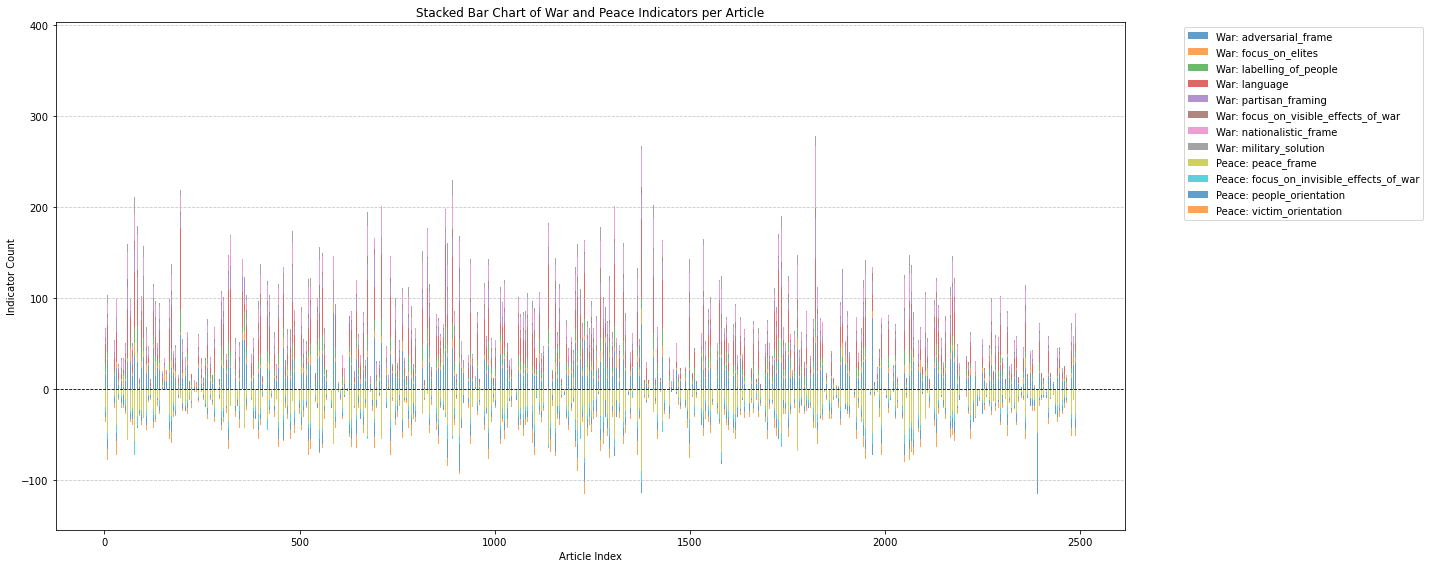

In [ ]:

# # Extract the keys for war and peace indicators
# war_keys = list(war_indicator_list[0].keys())
# peace_keys = list(peace_indicator_list[0].keys())

# # Prepare data for plotting
# indices = np.arange(len(war_indicator_list))  # Indices for the articles

# # Initialize the figure
# plt.figure(figsize=(20, 8))

# # Plot war indicators as stacked bars
# bottom_war = np.zeros(len(war_indicator_list))
# for key in war_keys:
#     values = [item[key] for item in war_indicator_list]
#     plt.bar(indices, values, width, bottom=bottom_war, label=f'War: {key}', alpha=0.7)
#     bottom_war += values

# # Plot peace indicators as stacked bars (negative values for bottom stacking)
# bottom_peace = np.zeros(len(peace_indicator_list))
# for key in peace_keys:
#     values = [-item[key] for item in peace_indicator_list]
#     plt.bar(indices, values, width, bottom=bottom_peace, label=f'Peace: {key}', alpha=0.7)
#     bottom_peace += values


# # Add labels and title
# plt.xlabel('Article Index')
# plt.ylabel('Indicator Count')
# plt.title('Stacked Bar Chart of War and Peace Indicators per Article')
# plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# # Show the plot
# plt.tight_layout()
# plt.show()

### Other indicator plots

In [109]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
  
stop_words = set(stopwords.words('english') + list(string.punctuation) + ['’',"'s"])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/arnav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/arnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/arnav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/arnav/nltk_data...


In [ ]:
data_dfs['ME'].columns

Index(['description', 'maintext', 'source_domain', 'title', 'url',
       'date_publish', 'region', 'title_len', 'text_len', 'adversarial_frame',
       'focus_on_elites', 'labelling_of_people', 'language',
       'partisan_framing', 'focus_on_visible_effects_of_war',
       'nationalistic_frame', 'military_solution', 'peace_frame',
       'focus_on_invisible_effects_of_war', 'peace_orientation',
       'people_orientation', 'victim_orientation', 'war_indicators',
       'peace_indicators'],
      dtype='object')

#### Elite vs People mentions

In [130]:
elite_results = {}
for region in ["US", "UK", "ME"]:
    elite_counter = Counter()
    for excerpt_list in data_dfs[region]['focus_on_elites'].values:
        # try:
        if isinstance(excerpt_list, list) and len(excerpt_list) > 0:
                for excerpt in excerpt_list:
                    # Check if excerpt is a string
                    if isinstance(excerpt, str):
                        # Tokenize the excerpt
                        tokens = word_tokenize(excerpt)
                        # Remove stop words
                        filtered_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
                        # Update the counter with filtered tokens
                        if len(filtered_tokens) < 10:
                            elite_counter.update(filtered_tokens)
    elite_results[region] = elite_counter.most_common(10)

In [131]:
elite_df = pd.DataFrame(elite_results)

In [132]:
people_orientation_results = {}
for region in ["US", "UK", "ME"]:
    people_counter = Counter()
    for excerpt_list in data_dfs[region]['people_orientation'].values:
        # try:
        if isinstance(excerpt_list, list) and len(excerpt_list) > 0:
            # Get the excerpt from the [excerpt, target, reasoning] list
            excerpt = excerpt_list[0]
            # Check if excerpt is a string
            if isinstance(excerpt, str):
                # Tokenize the excerpt
                tokens = word_tokenize(excerpt)
                # Remove stop words
                filtered_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
                # Update the counter with filtered tokens
                if len(filtered_tokens) < 10:
                    people_counter.update(filtered_tokens)
    people_orientation_results[region] = people_counter.most_common(10)

In [133]:
people_df = pd.DataFrame(people_orientation_results)

In [134]:
print(pd.concat([people_df, elite_df], axis=1).to_latex(index=False))

\begin{tabular}{llllll}
\toprule
              US &               UK &                ME &               US &               UK &                 ME \\
\midrule
  (civilian, 24) &     (people, 29) &      (people, 56) & (president, 861) &  (minister, 518) &     (israeli, 881) \\
      (gaza, 20) &     (family, 12) & (palestinian, 54) &     (biden, 649) & (president, 465) &    (minister, 788) \\
    (people, 14) &     (impact, 12) &        (gaza, 52) &   (israeli, 487) &     (biden, 405) &   (president, 539) \\
    (impact, 12) &   (conflict, 11) &       (child, 37) &  (minister, 399) &   (israeli, 344) &     (foreign, 473) \\
   (hostage, 11) &   (civilian, 10) &    (civilian, 32) & (netanyahu, 354) &     (prime, 277) &           (u, 373) \\
    (family, 11) &    (martial, 10) &       (woman, 28) &     (house, 333) & (netanyahu, 276) &       (hamas, 351) \\
  (conflict, 11) &       (focus, 9) &      (impact, 21) &     (prime, 297) & (secretary, 272) &    (official, 325) \\
      (focus, 

#### Visible vs Invisible effects of war

In [123]:
visible_results = {}
for region in ["US", "UK", "ME"]:
    visible_counter = Counter()
    for excerpt_list in data_dfs[region]['focus_on_visible_effects_of_war'].values:
        # try:
        if isinstance(excerpt_list, list) and len(excerpt_list) > 0:
                for excerpt in excerpt_list:
                    # Check if excerpt is a string
                    if isinstance(excerpt, str):
                        # Tokenize the excerpt
                        tokens = word_tokenize(excerpt)
                        # Remove stop words
                        filtered_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
                        # Update the counter with filtered tokens
                        if len(filtered_tokens) < 10:
                            visible_counter.update(filtered_tokens)
    visible_results[region] = visible_counter.most_common(10)

In [124]:
visible_df = pd.DataFrame(visible_results)

In [138]:
invisible_results = {}
for region in ["US", "UK", "ME"]:
    invisible_counter = Counter()
    for excerpt_list in data_dfs[region]['focus_on_invisible_effects_of_war'].values:
        # try:
        if isinstance(excerpt_list, list) and len(excerpt_list) > 0:
            # Get the excerpt from the [excerpt, target] list
            excerpt = excerpt_list[0]
            # Check if excerpt is a string
            if isinstance(excerpt, str):
                # Tokenize the excerpt
                tokens = word_tokenize(excerpt)
                # Remove stop words
                filtered_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
                # Update the counter with filtered tokens
                if len(filtered_tokens) < 10:
                    invisible_counter.update(filtered_tokens)
    invisible_results[region] = invisible_counter.most_common(10)

In [139]:
invisible_df = pd.DataFrame(invisible_results)

In [140]:
print(pd.concat([visible_df, invisible_df], axis=1).to_latex(index=False))

\begin{tabular}{llllll}
\toprule
                US &                 UK &                 ME &                 US &                 UK &                  ME \\
\midrule
       (gaza, 347) &        (gaza, 358) & (palestinian, 767) &       (impact, 19) &       (impact, 17) &        (impact, 42) \\
     (killed, 300) &      (killed, 341) &      (killed, 721) &    (potential, 12) &    (potential, 11) & (psychological, 29) \\
     (israel, 262) &      (people, 280) &        (gaza, 609) &       (article, 8) &       (trauma, 10) &        (trauma, 17) \\
      (hamas, 252) & (palestinian, 266) &      (people, 397) &      (conflict, 8) & (psychological, 8) &      (conflict, 12) \\
    (israeli, 246) &     (israeli, 234) &     (israeli, 386) & (psychological, 7) &     (emotional, 8) &          (gaza, 12) \\
    (hostage, 245) &       (death, 196) &       (death, 359) &     (long-term, 7) &      (conflict, 7) &     (long-term, 11) \\
     (people, 226) &      (israel, 182) &       (child, 354) &

In [155]:
consolidated_data = pd.concat(data_dfs.values(), axis=0)

In [160]:
len(consolidated_data)

7733

In [143]:
df = pd.read_csv("../data/processed/semantic_frame_annotated.csv", index_col=0)

In [146]:
df['url'].nunique()

1810

In [159]:
consolidated_data.merge(df, left_on='url', right_on='url', how='inner')

,description_x,maintext_x,source_domain_x,title_x,url,date_publish_x,region_x,title_len_x,text_len_x,adversarial_frame,...,maintext_y,source_domain_y,title_y,language_y,date_publish_y,region_y,title_len_y,text_len_y,frame,reasoning
0,Dozens of Hamas terrorists surrendered to Isra...,Dozens of Hamas terrorists surrendered to Isra...,nypost.com,Dozens of Hamas terrorists surrender to Israel...,https://nypost.com/2023/12/07/news/dozens-of-h...,2023-12-07 15:45:00,US,8,648,{'use_of_adversarial_language': [['Dozens of H...,...,Dozens of Hamas terrorists surrendered to Isra...,nypost.com,Dozens of Hamas terrorists surrender to Israel...,en,2023-12-07 15:45:00,US,8,648,Security and defense,The article discusses the IDF's military actio...
1,"Host of Outkick's ""Tomi Lahren is Fearless"" To...",Host of Outkick’s “Tomi Lahren is Fearless” To...,radio.foxnews.com,Tomi Lahren: These Anti-Israel Protesters Are ...,https://radio.foxnews.com/2023/11/06/tomi-lahr...,2023-11-06 15:51:30,US,18,184,{'use_of_adversarial_language': [['These are a...,...,Host of Outkick’s “Tomi Lahren is Fearless” To...,radio.foxnews.com,Tomi Lahren: These Anti-Israel Protesters Are ...,en,2023-11-06 15:51:30,US,18,184,ERROR,Expecting value: line 1 column 2 (char 1)
2,Memorial services were held across Israel toda...,Memorial services were held across Israel toda...,radio.foxnews.com,Evening Edition: Hundreds Of Hostages Remain I...,https://radio.foxnews.com/2023/11/07/evening-e...,2023-11-07 18:30:28,US,13,90,{'use_of_adversarial_language': [['Memorial se...,...,Memorial services were held across Israel toda...,radio.foxnews.com,Evening Edition: Hundreds Of Hostages Remain I...,en,2023-11-07 18:30:28,US,13,90,Security and defense,The article describes a war between Israel and...
3,A group of pro-Palestinian protesters attempte...,A group of anti-Israel protesters who particip...,www.breitbart.com,WATCH: Anti-Israel Protesters Try to Storm Whi...,https://www.breitbart.com/politics/2023/11/04/...,2023-11-05 04:53:39,US,12,487,{'use_of_adversarial_language': [['anti-Israel...,...,A group of anti-Israel protesters who particip...,www.breitbart.com,WATCH: Anti-Israel Protesters Try to Storm Whi...,en,2023-11-05 04:53:39,US,12,487,Fairness and equality,The article describes a protest where particip...
4,Actor and comedian Michael Rapaport ranted abo...,{{#rendered}} {{/rendered}}\nComedian Michael ...,www.foxnews.com,Michael Rapaport demands Hamas reveal themselv...,https://www.foxnews.com/media/michael-rapaport...,2023-11-28 06:00:33,US,14,485,{'use_of_adversarial_language': [['Why hasn’t ...,...,{{#rendered}} {{/rendered}}\nComedian Michael ...,www.foxnews.com,Michael Rapaport demands Hamas reveal themselv...,en,2023-11-28 06:00:33,US,14,485,Fairness and equality,The comedian Michael Rapaport is questioning w...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,"""Netanyahu suspended a government minister who...",Social media users say the comments by the Isr...,dohanews.co,‘We told you they are genocidal’: World reacts...,https://dohanews.co/we-told-you-they-are-genoc...,2023-11-05 13:11:30,ME,14,1011,{'use_of_adversarial_language': [['Israeli for...,...,Social media users say the comments by the Isr...,dohanews.co,‘We told you they are genocidal’: World reacts...,en,2023-11-05 13:11:30,ME,14,1011,"Legality, constitutionality and jurisprudence","The comments by the Israeli heritage minister,..."
709,"CAIRO, Nov 23 (MENA) - Egypt’s Decent Life ini...","CAIRO, Nov 23 (MENA) – Egypt’s Decent Life ini...",www.egyptindependent.com,'Decent Live' dispatches 100 relief trucks car...,https://www.egyptindependent.com/decent-live-d...,2023-11-24 10:34:19,ME,13,266,{'use_of_adversarial_language': [['Israeli off...,...,"CAIRO, Nov 23 (MENA) – Egypt’s Decent Life ini...",www.egyptindependent.com,'Decent Live' dispatches 100 relief trucks car...,en,2023-11-24 10:34:19,ME,13,266,ERROR,Extra data: line 6 column 2 (char 951)
710,Arab countrie

In [177]:
frame_semantics = {}
for region in ["US", "UK", "MiddleEast"]:
    frame_semantics[region] = pickle.load(open(f"../data/processed/doc_semantics/frame_semantics_{region}_main.pickle", "rb"))

In [178]:
for region in ["US", "UK", "MiddleEast"]:
    df = pd.read_csv(f"../data/raw/framing_results/selected_{region}.csv")
    print(region, len(df))
    print(len(set(df.index) - set(range(len(df)))))

US 9629
0
UK 8150
0
MiddleEast 4145
0


In [ ]:
for region in ["US", "UK", "ME"]:
    df = pd.read_json(f"../data/processed/{region}_framing.jsonl", lines=True)

US 2522
0
UK 2492
0
ME 2719
0


In [180]:
df.columns

Index(['description', 'maintext', 'source_domain', 'title', 'url',
       'date_publish', 'region', 'title_len', 'text_len', 'adversarial_frame',
       'focus_on_elites', 'labelling_of_people', 'language',
       'partisan_framing', 'focus_on_visible_effects_of_war',
       'nationalistic_frame', 'military_solution', 'peace_frame',
       'focus_on_invisible_effects_of_war', 'peace_orientation',
       'people_orientation', 'victim_orientation'],
      dtype='object')